# REINFORCEMENT LEARNING ALGORITHMS WITH CARTPOLE ENV

## Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import tensorflow as tf
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Note: there may be minor differences between the output of this notebook and the examples shown in the book. You can safely ignore these differences. They are mainly due to the fact that most of the environments provided by OpenAI gym have some randomness.

In this notebook we will be using OpenAI gym, a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning agents to interact with. Let's start by importing gym:

In [2]:
reset_graph()
import gym

The Cart-Pole is a very simple environment composed of a cart that can move left or right, and pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright.

In [3]:
env = gym.make("CartPole-v0")

In [4]:
obs = env.reset()

In [5]:
print("obs:",obs)

obs: [-0.03671611 -0.04649316  0.0416528   0.04471463]


The observation is a 1D NumPy array composed of 4 floats: they represent the cart's horizontal position, its velocity, the angle of the pole (0 = vertical), and the angular velocity. Let's render the environment... unfortunately we need to fix an annoying rendering issue first.

In [6]:
from PIL import Image, ImageDraw

try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True   # no problem, let's use OpenAI gym's rendering function
except Exception:
    openai_cart_pole_rendering = False  # probably no X server available, let's use our own rendering function

def render_cart_pole(env, obs):
    if openai_cart_pole_rendering:
        # use OpenAI gym's rendering function
        return env.render(mode="rgb_array")
    else:
        # rendering for the cart pole environment (in case OpenAI gym can't do it)
        img_w = 600
        img_h = 400
        cart_w = img_w // 12
        cart_h = img_h // 15
        pole_len = img_h // 3.5
        pole_w = img_w // 80 + 1
        x_width = 2
        max_ang = 0.2
        bg_col = (255, 255, 255)
        cart_col = 0x000000 # Blue Green Red
        pole_col = 0x669acc # Blue Green Red

        pos, vel, ang, ang_vel = obs
        img = Image.new('RGB', (img_w, img_h), bg_col)
        draw = ImageDraw.Draw(img)
        cart_x = pos * img_w // x_width + img_w // x_width
        cart_y = img_h * 95 // 100
        top_pole_x = cart_x + pole_len * np.sin(ang)
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
        return np.array(img)

def plot_cart_pole(env, obs):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [7]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

In [8]:
openai_cart_pole_rendering = False  # don't try, just use the safe way?

<IPython.core.display.Javascript object>


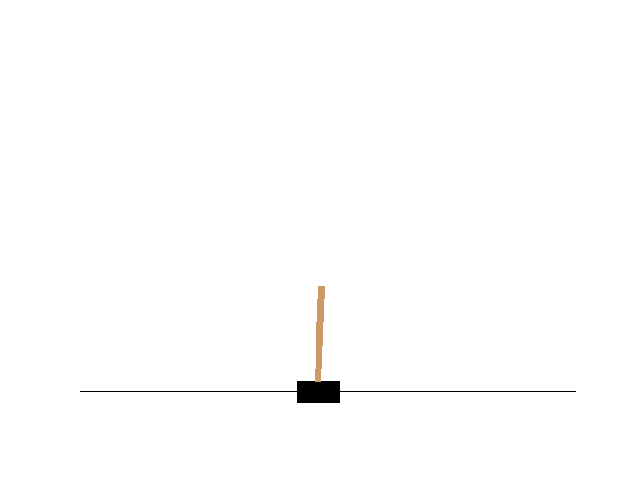

In [9]:
plot_cart_pole(env, obs)

Now let's look at the action space:

In [10]:
print("Env action space:",env.action_space)

Env action space: Discrete(2)


Yep, just two possible actions: accelerate towards the left or towards the right. Let's push the cart left until the pole falls:

In [11]:
obs = env.reset()
while True:
    obs, reward, done, info = env.step(0) # 0 means left
    if done:
        break

<IPython.core.display.Javascript object>


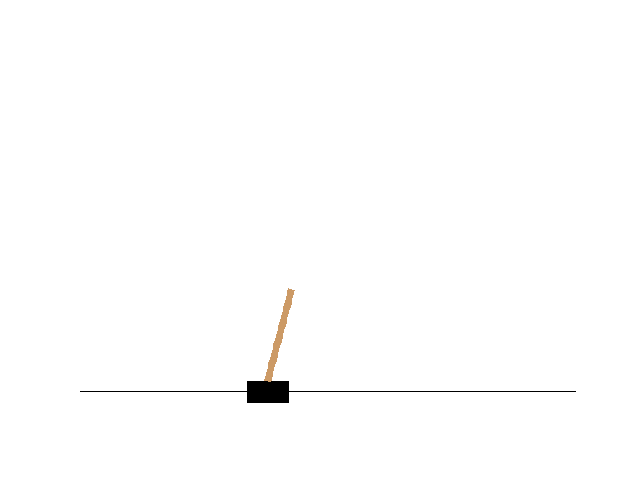

In [12]:
plot_cart_pole(env, obs)

Notice that the game is over when the pole tilts too much, not when it actually falls. Now let's reset the environment and push the cart to right instead:

In [13]:
obs = env.reset()
while True:
    obs, reward, done, info = env.step(1)
    if done:
        break

<IPython.core.display.Javascript object>


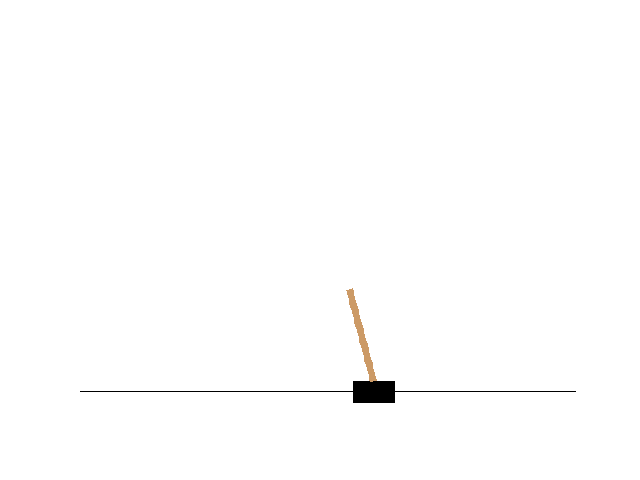

In [14]:
plot_cart_pole(env, obs)

Looks like it's doing what we're telling it to do. Now how can we make the poll remain upright? We will need to define a policy for that. This is the strategy that the agent will use to select an action at each step. It can use all the past actions and observations to decide what to do.

## A simple hard-coded policy

Let's hard code a simple strategy: if the pole is tilting to the left, then push the cart to the left, and vice versa. Let's see if that works:


In [15]:
frames = []

# number of iterations
n_max_steps = 1000
n_change_steps = 10

obs = env.reset()
for step in range(n_max_steps):
    # capture the image and append it to the video frame
    img = render_cart_pole(env, obs)
    frames.append(img)
    
    # extract the new observations
    position, velocity, angle, angular_velocity = obs
    
    # hard-coded policy
    if angle < 0:
        action = 0
    else:
        action = 1
    # take action 1 or 0 based on the hard coded policy
    obs, reward, done, info = env.step(action)
    
    #break out of iteration if the pole falls off 
    if done:
        break
        
print(step)

30


<IPython.core.display.Javascript object>


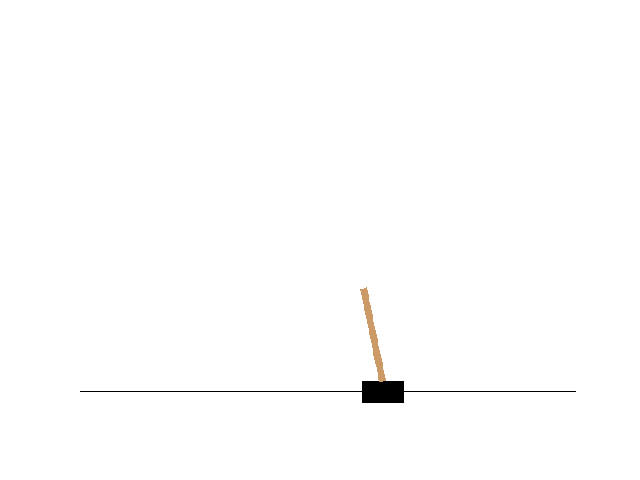

In [16]:
video = plot_animation(frames)
plt.show()

Nope, the system is unstable and after just a few wobbles, the pole ends up too tilted: game over. We will need to be smarter than that!

## Neural Network Policies

Let's create a neural network that will take observations as inputs, and output the action to take for each observation. To choose an action, the network will first estimate a probability for each action, then select an action randomly according to the estimated probabilities. In the case of the Cart-Pole environment, there are just two possible actions (left or right), so we only need one output neuron: it will output the probability p of the action 0 (left), and of course the probability of action 1 (right) will be 1 - p.

Note: instead of using the fully_connected() function from the tensorflow.contrib.layers module (as in the book), we now use the dense() function from the tf.layers module, which did not exist when this chapter was written. This is preferable because anything in contrib may change or be deleted without notice, while tf.layers is part of the official API. As you will see, the code is mostly the same.

The main differences relevant to this chapter are:

the _fn suffix was removed in all the parameters that had it (for example the activation_fn parameter was renamed to activation).

the weights parameter was renamed to kernel,

the default activation is None instead of tf.nn.relu



In [17]:
# 1. Specify the network architecture
n_inputs = 4  # == env.observation_space.shape[0]
n_hidden = 4  # it's a simple task, we don't need more than this
n_outputs = 1 # only outputs the probability of accelerating left
initializer = tf.variance_scaling_initializer()

In [18]:
reset_graph()

In [19]:
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

In [20]:
hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu,
                         kernel_initializer=initializer)
print(hidden)

Tensor("dense/Elu:0", shape=(?, 4), dtype=float32)


In [21]:
outputs = tf.layers.dense(hidden, n_outputs, activation=tf.nn.sigmoid,
                          kernel_initializer=initializer)
print(outputs)

Tensor("dense_1/Sigmoid:0", shape=(?, 1), dtype=float32)


In [22]:
p_left_and_right = tf.concat(axis=1, values=[outputs, 1-outputs])
print(p_left_and_right)

Tensor("concat:0", shape=(?, 2), dtype=float32)


In [23]:
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)
print(action)

Tensor("multinomial/Multinomial:0", shape=(?, 1), dtype=int64)


In [24]:
init = tf.global_variables_initializer()

In [25]:
# number of steps
n_max_steps = 1000
frames = []

with tf.Session() as sess:
    init.run()
    
    # initialize enviroment
    obs = env.reset()
    
    # running the action designated number of times
    for step in range(n_max_steps):
        # extract image and append it to the frame
        img = render_cart_pole(env, obs)
        frames.append(img)
        # evaluate action based on neural network and the single observation
        action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
        # take action based on the action evaluated by the graph
        obs, reward, done, info = env.step(action_val[0][0])
        # break out of iteration if the poll falls off
        if done:
            break
env.close()

In [27]:
print("Action value:",action_val)

Action value: [[1]]


In [28]:
obs.reshape(1, n_inputs)

array([[ 0.31222825,  1.76564531, -0.24740894, -2.25444343]])

<IPython.core.display.Javascript object>


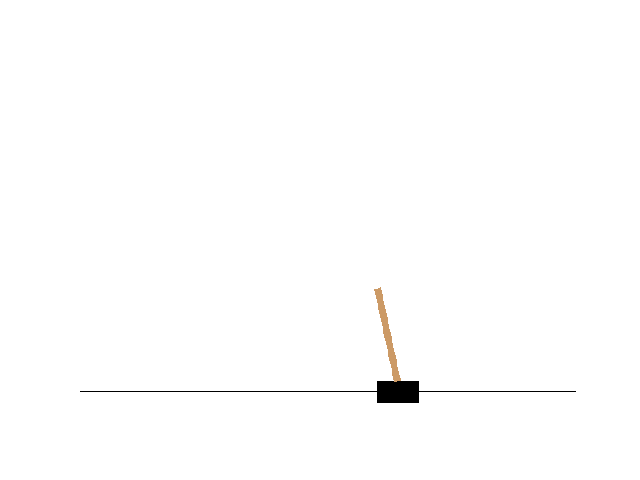

In [29]:
video = plot_animation(frames)
plt.show()

Yeah... pretty bad. The neural network will have to learn to do better. First let's see if it is capable of learning the basic policy we used earlier: go left if the pole is tilting left, and go right if it is tilting right. The following code defines the same neural network but we add the target probabilities y, and the training operations (cross_entropy, optimizer and training_op):

In [30]:
reset_graph()

In [31]:
# 1. Specify the network architecture
n_inputs = 4  # == env.observation_space.shape[0]
n_hidden = 4  # it's a simple task, we don't need more than this
n_outputs = 1 # only outputs the probability of accelerating left
learning_rate = 0.01
initializer = tf.variance_scaling_initializer()

In [32]:
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.float32, shape=[None, n_outputs])

In [33]:
hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits) # probability of action 0 (left)
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

In [34]:
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(cross_entropy)

In [35]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

We can make the same net play in 10 different environments in parallel, and train for 1000 iterations. We also reset environments when they are done.

In [36]:
# number of parallel enviroments
n_environments = 10
# number of iterations each enviroment will go through
n_iterations = 1000
# create multiple enviroments
envs = [gym.make("CartPole-v0") for _ in range(n_environments)]
# initilize the observation of the created enviroments
observations = [env.reset() for env in envs]

In [37]:
print("Enviroments:","\n",envs)

Enviroments: 
 [<TimeLimit<CartPoleEnv<CartPole-v0>>>, <TimeLimit<CartPoleEnv<CartPole-v0>>>, <TimeLimit<CartPoleEnv<CartPole-v0>>>, <TimeLimit<CartPoleEnv<CartPole-v0>>>, <TimeLimit<CartPoleEnv<CartPole-v0>>>, <TimeLimit<CartPoleEnv<CartPole-v0>>>, <TimeLimit<CartPoleEnv<CartPole-v0>>>, <TimeLimit<CartPoleEnv<CartPole-v0>>>, <TimeLimit<CartPoleEnv<CartPole-v0>>>, <TimeLimit<CartPoleEnv<CartPole-v0>>>]


In [38]:
print("observations:","\n", observations)

observations: 
 [array([ 0.0032322 ,  0.02624884, -0.04096696, -0.0354603 ]), array([ 0.03979925, -0.04207284,  0.04206159, -0.02912197]), array([ 0.01625143, -0.01667158, -0.00702943,  0.00393568]), array([ 0.03812472, -0.02643919, -0.01007655, -0.01932909]), array([ 0.02235318, -0.02483305, -0.0373885 ,  0.01579519]), array([ 0.01380089,  0.02294407,  0.0220571 , -0.04104702]), array([0.00129126, 0.02832902, 0.03744765, 0.02693643]), array([-0.04835202,  0.03443037, -0.01767889,  0.04007862]), array([-0.01586221,  0.00028439,  0.01467323, -0.03666699]), array([ 0.00433061,  0.03287864, -0.01845835,  0.02369671])]


In [39]:
with tf.Session() as sess:
    # initialize variables
    init.run()
    
    # optimization iteration
    for iteration in range(n_iterations):
        
        # if angle<0 we want proba(left)=1., or else proba(left)=0.
        target_probas = np.array([([1.] if obs[2] < 0 else [0.]) for obs in observations])
        # evaluate the action based on the deep learning graph by feeding the observations & calculated target probabilities
        # compute optimization step
        action_val, _ = sess.run([action, training_op], 
                                 feed_dict={X: np.array(observations),
                                            y: target_probas})
        
        # itarate through each enviroments
        # take action based on the action evaluated by the graph for that enviroments
        # inpect if the poll is done and set observation based on that
        for env_index, env in enumerate(envs):
            obs, reward, done, info = env.step(action_val[env_index][0])
            # if the pole is alive (not done) then set then update the observation
            # if the pole is done (fell off) then reinitilize the env and set the observation to the initial obs
            observations[env_index] = obs if not done else env.reset()
    saver.save(sess, "./reinforcement_algo_1/my_policy_net_basic.ckpt")

# close all enviroments
for env in envs:
    env.close()

In [42]:
print("target prob:","\n",target_probas)

target prob: 
 [[1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]]


In [43]:
print("action_val:","\n",action_val)

action_val: 
 [[0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]]


In [44]:
print("observations:","\n",observations)

observations: 
 [array([ 0.24144043,  1.19076114, -0.20633914, -1.46234669]), array([-0.07662636,  0.19197479,  0.03299177, -0.27323194]), array([ 0.02890087,  1.49690983,  0.00561961, -1.95688763]), array([-0.00741001,  0.74030851, -0.08859447, -1.10827886]), array([-1.33405574e-03,  1.37649114e+00, -6.78759630e-03, -1.84892942e+00]), array([ 0.01049049,  0.57124368,  0.003757  , -0.77329607]), array([ 0.03950672, -0.17400755, -0.01246729,  0.29413651]), array([-0.0729383 ,  0.93770779,  0.01884975, -1.3230131 ]), array([-0.04726574, -0.18380144,  0.00050964,  0.31853333]), array([ 0.1111521 , -0.39665713, -0.20609163,  0.29428092])]


In [45]:
def render_policy_net(model_path, action, X, n_max_steps = 1000):
    frames = []
    env = gym.make("CartPole-v0")
    obs = env.reset()
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            img = render_cart_pole(env, obs)
            frames.append(img)
            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            if done:
                break
    env.close()
    return frames

INFO:tensorflow:Restoring parameters from ./reinforcement_algo_1/my_policy_net_basic.ckpt


<IPython.core.display.Javascript object>


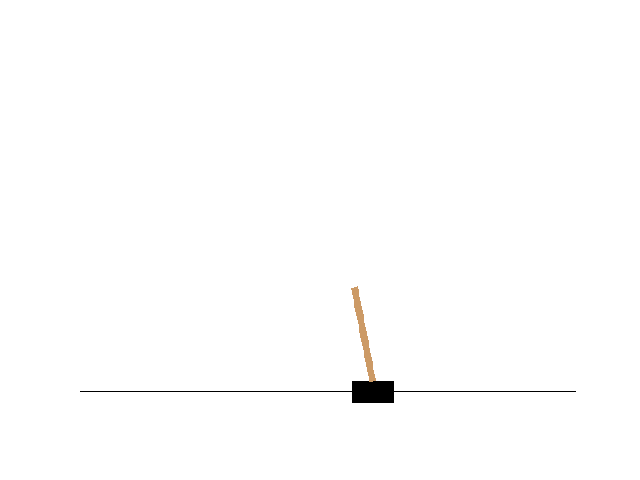

In [46]:
frames = render_policy_net("./reinforcement_algo_1/my_policy_net_basic.ckpt", action, X)
video = plot_animation(frames)
plt.show()

## Policy Gradients

To train this neural network we will need to define the target probabilities y. If an action is good we should increase its probability, and conversely if it is bad we should reduce it. But how do we know whether an action is good or bad? The problem is that most actions have delayed effects, so when you win or lose points in a game, it is not clear which actions contributed to this result: was it just the last action? Or the last 10? Or just one action 50 steps earlier? This is called the credit assignment problem.

The Policy Gradients algorithm tackles this problem by first playing multiple games, then making the actions in good games slightly more likely, while actions in bad games are made slightly less likely. First we play, then we go back and think about what we did.

In [47]:
reset_graph()

In [48]:
n_inputs = 4
n_hidden = 4
n_outputs = 1
learning_rate = 0.01
initializer = tf.contrib.layers.variance_scaling_initializer()

In [49]:
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

In [50]:
hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits)  # probability of action 0 (left)
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

In [51]:
y = 1. - tf.to_float(action)

In [52]:
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)

In [53]:
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]
variables = [variable for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []

In [54]:
print("gradients:","\n",gradients)

gradients: 
 [<tf.Tensor 'gradients/dense/MatMul_grad/tuple/control_dependency_1:0' shape=(4, 4) dtype=float32>, <tf.Tensor 'gradients/dense/BiasAdd_grad/tuple/control_dependency_1:0' shape=(4,) dtype=float32>, <tf.Tensor 'gradients/dense_1/MatMul_grad/tuple/control_dependency_1:0' shape=(4, 1) dtype=float32>, <tf.Tensor 'gradients/dense_1/BiasAdd_grad/tuple/control_dependency_1:0' shape=(1,) dtype=float32>]


In [55]:
print("variables:","\n",variables)

variables: 
 [<tf.Variable 'dense/kernel:0' shape=(4, 4) dtype=float32_ref>, <tf.Variable 'dense/bias:0' shape=(4,) dtype=float32_ref>, <tf.Variable 'dense_1/kernel:0' shape=(4, 1) dtype=float32_ref>, <tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32_ref>]


In [56]:
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))

In [57]:
print("gradient_placeholders:","\n",gradient_placeholders)

gradient_placeholders: 
 [<tf.Tensor 'Placeholder_1:0' shape=(4, 4) dtype=float32>, <tf.Tensor 'Placeholder_2:0' shape=(4,) dtype=float32>, <tf.Tensor 'Placeholder_3:0' shape=(4, 1) dtype=float32>, <tf.Tensor 'Placeholder_4:0' shape=(1,) dtype=float32>]


In [58]:
print("grads_and_vars_feed:","\n",grads_and_vars_feed)

grads_and_vars_feed: 
 [(<tf.Tensor 'Placeholder_1:0' shape=(4, 4) dtype=float32>, <tf.Variable 'dense/kernel:0' shape=(4, 4) dtype=float32_ref>), (<tf.Tensor 'Placeholder_2:0' shape=(4,) dtype=float32>, <tf.Variable 'dense/bias:0' shape=(4,) dtype=float32_ref>), (<tf.Tensor 'Placeholder_3:0' shape=(4, 1) dtype=float32>, <tf.Variable 'dense_1/kernel:0' shape=(4, 1) dtype=float32_ref>), (<tf.Tensor 'Placeholder_4:0' shape=(1,) dtype=float32>, <tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32_ref>)]


In [59]:
training_op = optimizer.apply_gradients(grads_and_vars_feed)

In [60]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

In [61]:
discount_rewards([10,0,-50], discount_rate=0.8)

array([-22., -40., -50.])

In [62]:
discount_and_normalize_rewards([[10,0,-50], [10,20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [63]:
env = gym.make("CartPole-v0")
n_iterations = 250
n_games_per_update = 10
n_max_steps = 1000
save_iterations = 10
discount_rate = 0.95

In [64]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    
    init.run()
    
    for iteration in range(n_iterations):
        
        print("\rIteration: {}".format(iteration), end="")
        
        all_rewards = []
        all_gradients = []
        
        for game in range(n_games_per_update):
            
            current_rewards = []
            current_gradients = []
            
            obs = env.reset()
            
            for step in range(n_max_steps):
                
                action_val, gradients_val = sess.run([action, gradients], feed_dict={X: obs.reshape(1, n_inputs)})
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                
                if done:
                    break
                    
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        
        feed_dict = {}
        
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            
            feed_dict[gradient_placeholder] = mean_gradients
            
        sess.run(training_op, feed_dict=feed_dict)
        
        if iteration % save_iterations == 0:
            saver.save(sess, "./reinforcement_algo_2/my_policy_net_pg.ckpt")
            


env.close()

Iteration: 249

INFO:tensorflow:Restoring parameters from ./reinforcement_algo_2/my_policy_net_pg.ckpt


<IPython.core.display.Javascript object>


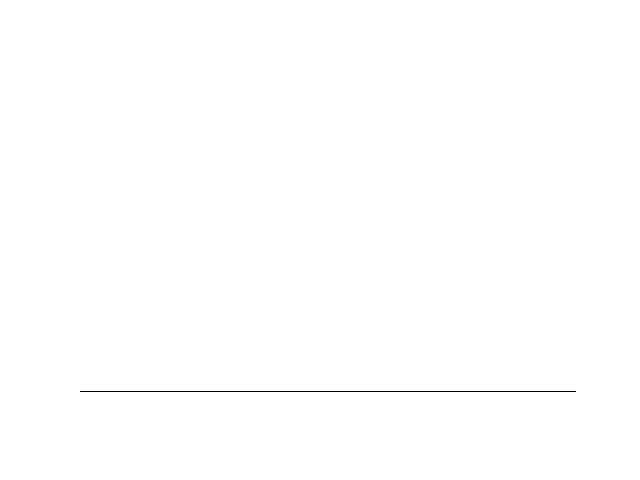

In [65]:
frames = render_policy_net("./reinforcement_algo_2/my_policy_net_pg.ckpt", action, X, n_max_steps=1000)
video = plot_animation(frames)
plt.show()